In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

sns.set_style('whitegrid')

In [50]:
from numpy.linalg import inv
from numpy.random import multivariate_normal
from scipy.stats import invwishart

class MVNMean:
    def __init__(self, μ0, Σ0):
        self.μ0 = μ0
        self.Σ0 = Σ0
        self.Λ0 = inv(Σ0)
    
    def sample_prior(self, size=1):
        return multivariate_normal(self.μ0, self.Σ0, size=size)
    
    def sample_posterior(self, X, Σ, size=1):
        n = X.shape[0]
        X_mean = X.mean(axis=0)

        Λ = inv(Σ)
        Λn = self.Λ0 + n * Λ
        Σn = inv(Λn)
        μn = Σn @ (Λ @ (n*X_mean) + self.Λ0 @ self.μ0)
        return multivariate_normal(μn, Σn, size=size)

class MVNSigma:
    def __init__(self, ν0, S0):
        self.ν0 = ν0
        self.S0 = S0
    
    def sample_prior(self, size=1):
        return invwishart(self.ν0, self.S0).rvs(size=size)
    
    def sample_posterior(self, X, θ, size=1):
        n = X.shape[0]
        S = (X - θ).T @ (X - θ)

        νn = self.ν0 + n
        Sn = self.S0 + S
        return invwishart(νn, Sn).rvs(size=size)

In [34]:
df = pd.read_fwf("azdiabetes.dat", skiprows=[0], header=None)
df.columns = "npreg glu bp skin bmi ped age diabetes".split()
df.diabetes = df.diabetes == 'Yes'

In [66]:
df_d = df[df.diabetes].drop(['diabetes'], axis=1)
df_n = df[~df.diabetes].drop(['diabetes'], axis=1)

In [97]:
X = df_d.values
N = df_d.shape[0]

# prior parameters
θ_rv = MVNMean(
    μ0 = df_d.mean().values,
    Σ0 = df_d.cov().values,
)

Σ_rv = MVNSigma(
    ν0 = df_d.shape[1] + 2,
    S0 = df_d.cov().values,
)

nEpochs = 10000
samples = []

Σ = Σ_rv.sample_prior()
θ = θ_rv.sample_prior().ravel()
for epoch in range(nEpochs):
    θ = θ_rv.sample_posterior(X, Σ).ravel()
    Σ = Σ_rv.sample_posterior(X, θ)

    samples.append(θ)

d_samples = pd.DataFrame(samples, columns=df.columns[:-1])

In [99]:
X = df_n.values
N = df_n.shape[0]

# prior parameters
θ_rv = MVNMean(
    μ0 = df_n.mean().values,
    Σ0 = df_n.cov().values,
)

Σ_rv = MVNSigma(
    ν0 = df_n.shape[1] + 2,
    S0 = df_n.cov().values,
)

nEpochs = 10000
samples = []

Σ = Σ_rv.sample_prior()
θ = θ_rv.sample_prior().ravel()
for epoch in range(nEpochs):
    θ = θ_rv.sample_posterior(X, Σ).ravel()
    Σ = Σ_rv.sample_posterior(X, θ)

    samples.append(θ)

n_samples = pd.DataFrame(samples, columns=df.columns[:-1])

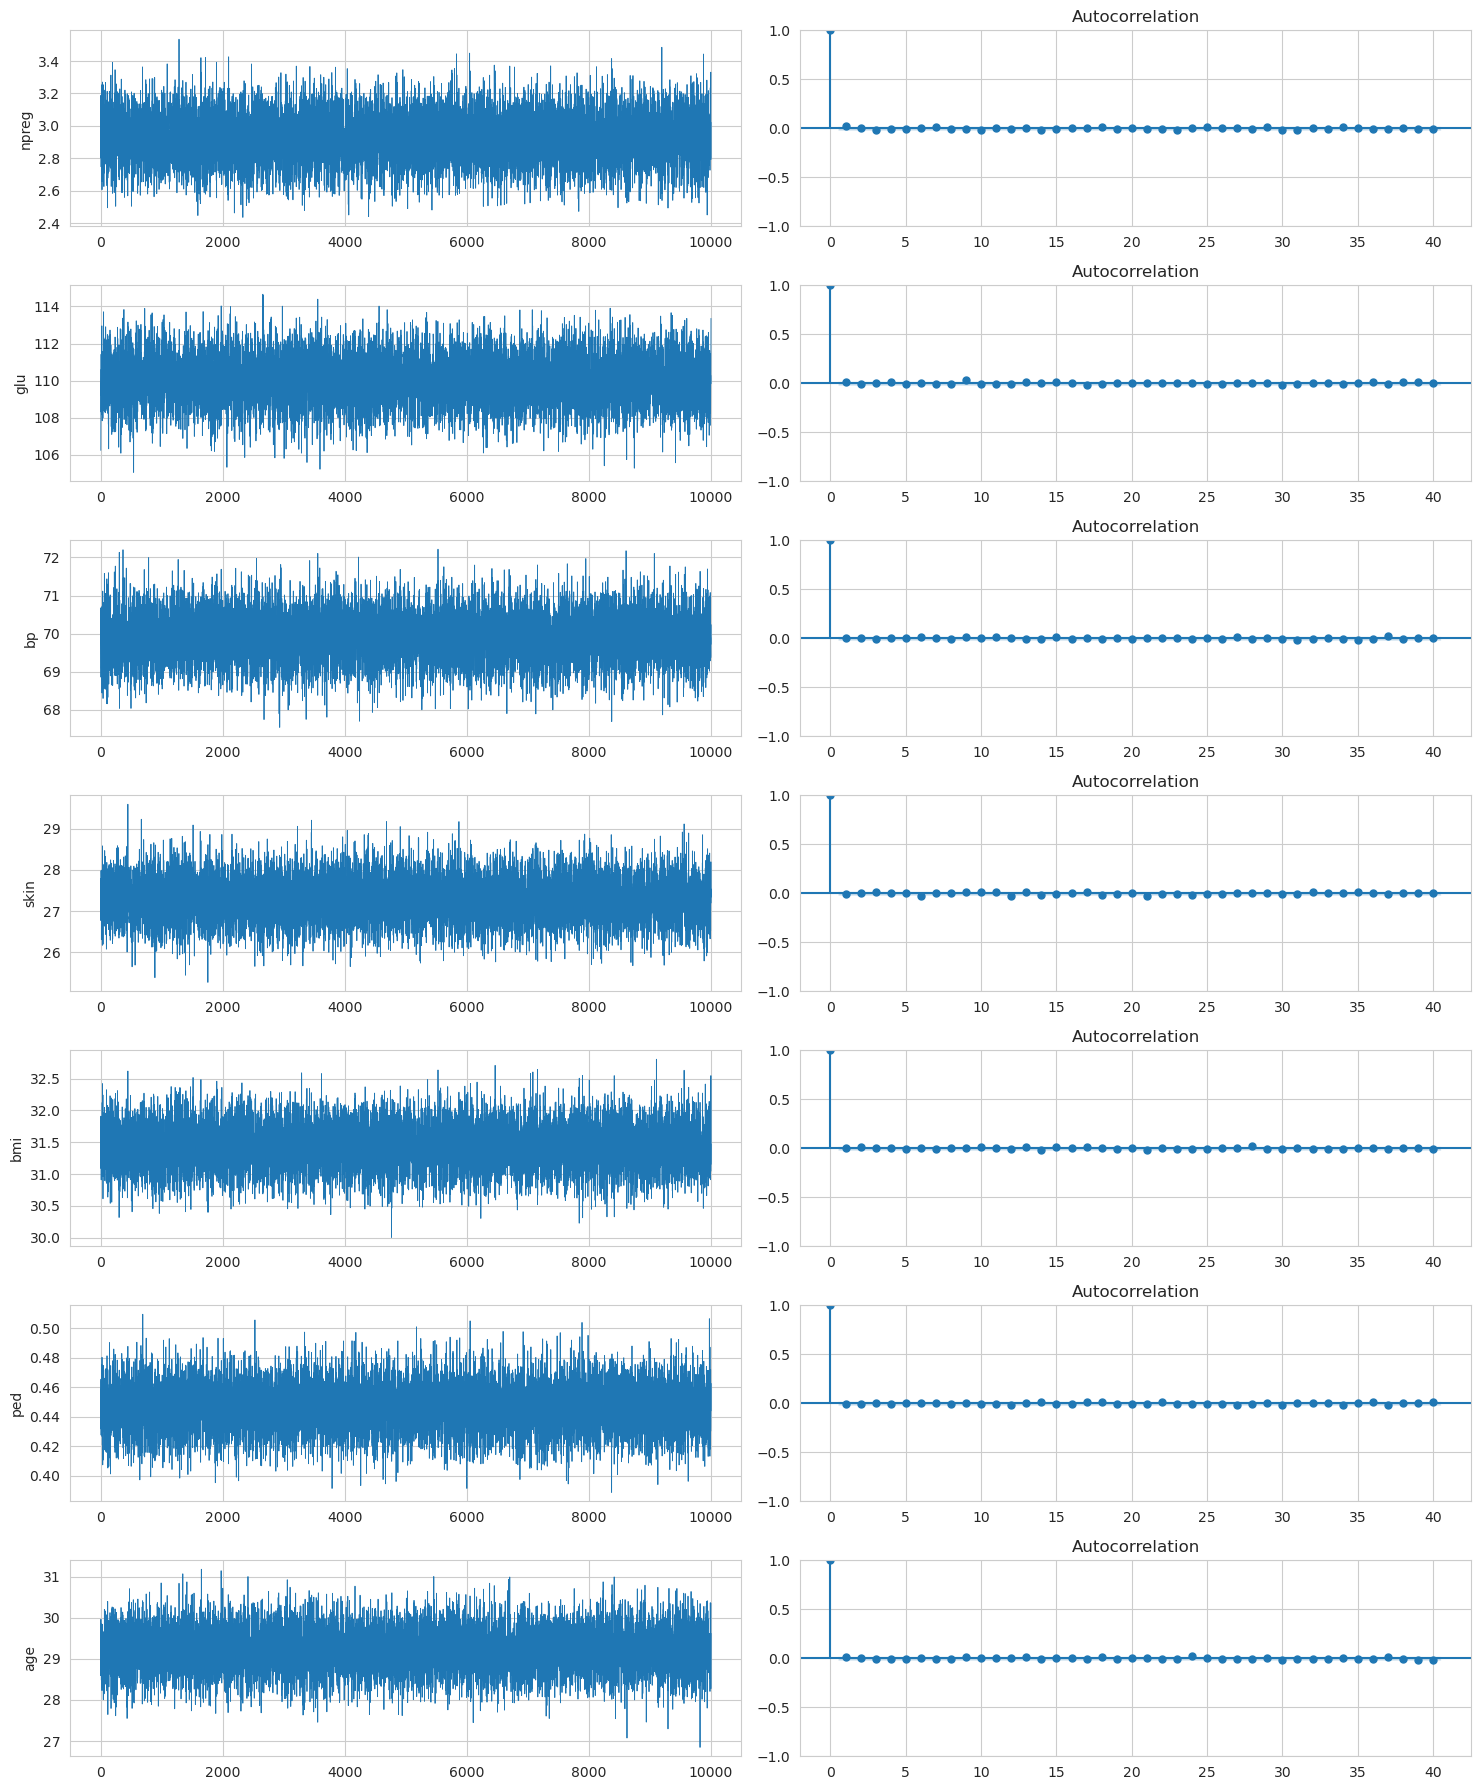

In [102]:
fig, ax = plt.subplots(7, 2, figsize=(15, 18))

for i, (col_name, sr) in enumerate(n_samples.iteritems()):
    sr.plot(linewidth=0.6, label=col_name, ax=ax[i, 0])
    sm.graphics.tsa.plot_acf(sr, ax=ax[i, 1])
    ax[i, 0].set_ylabel(col_name)

fig.tight_layout()
fig.show()

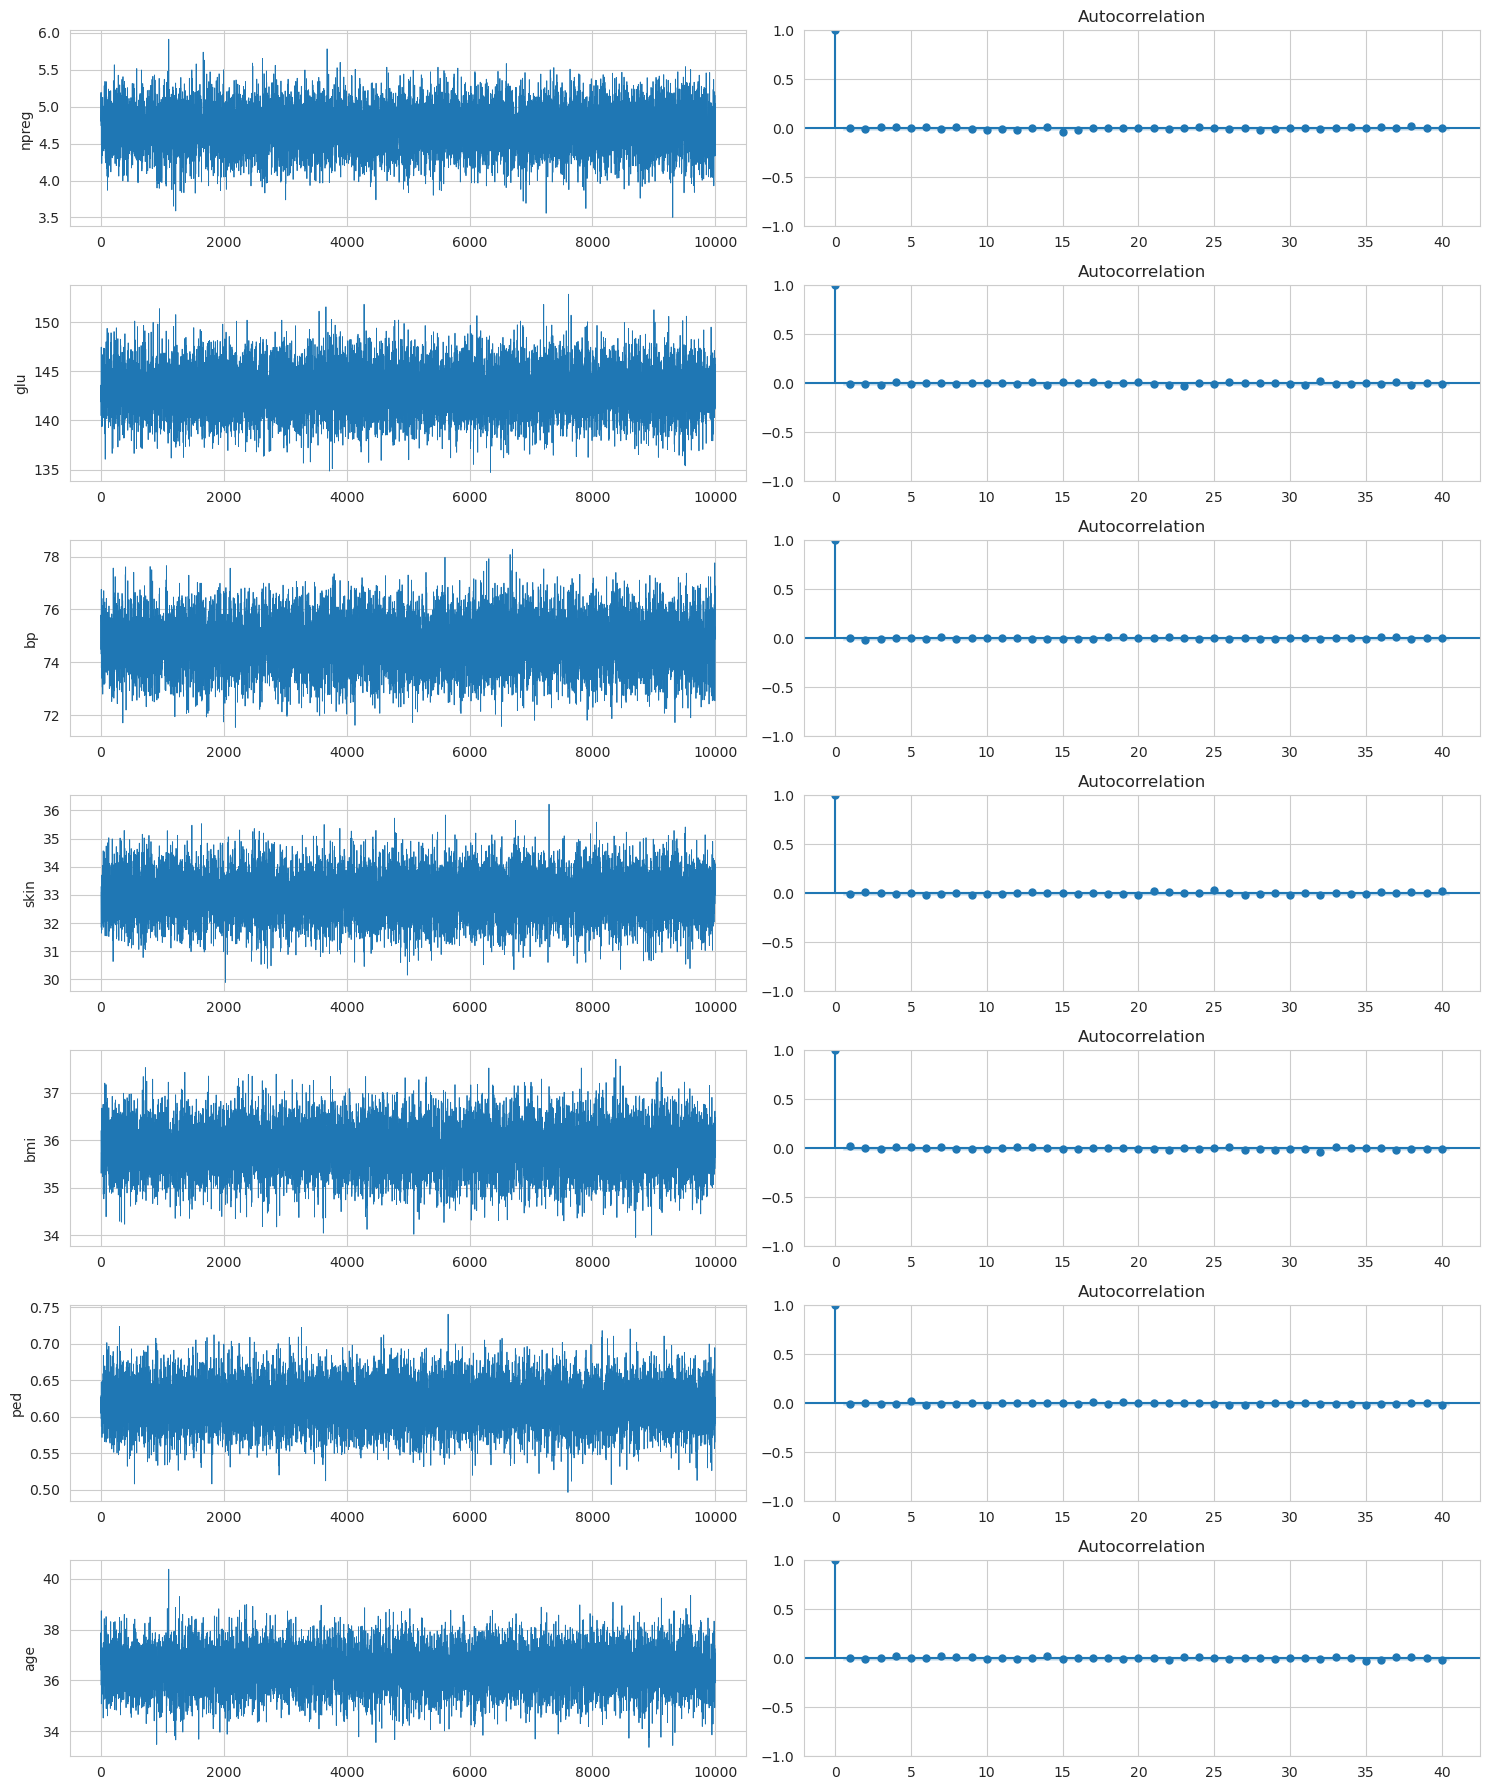

In [103]:
fig, ax = plt.subplots(7, 2, figsize=(15, 18))

for i, (col_name, sr) in enumerate(d_samples.iteritems()):
    sr.plot(linewidth=0.6, label=col_name, ax=ax[i, 0])
    sm.graphics.tsa.plot_acf(sr, ax=ax[i, 1])
    ax[i, 0].set_ylabel(col_name)

fig.tight_layout()
fig.show()

age 1.0
age 1.0
age 1.0
age 1.0
age 1.0
age 1.0
age 1.0


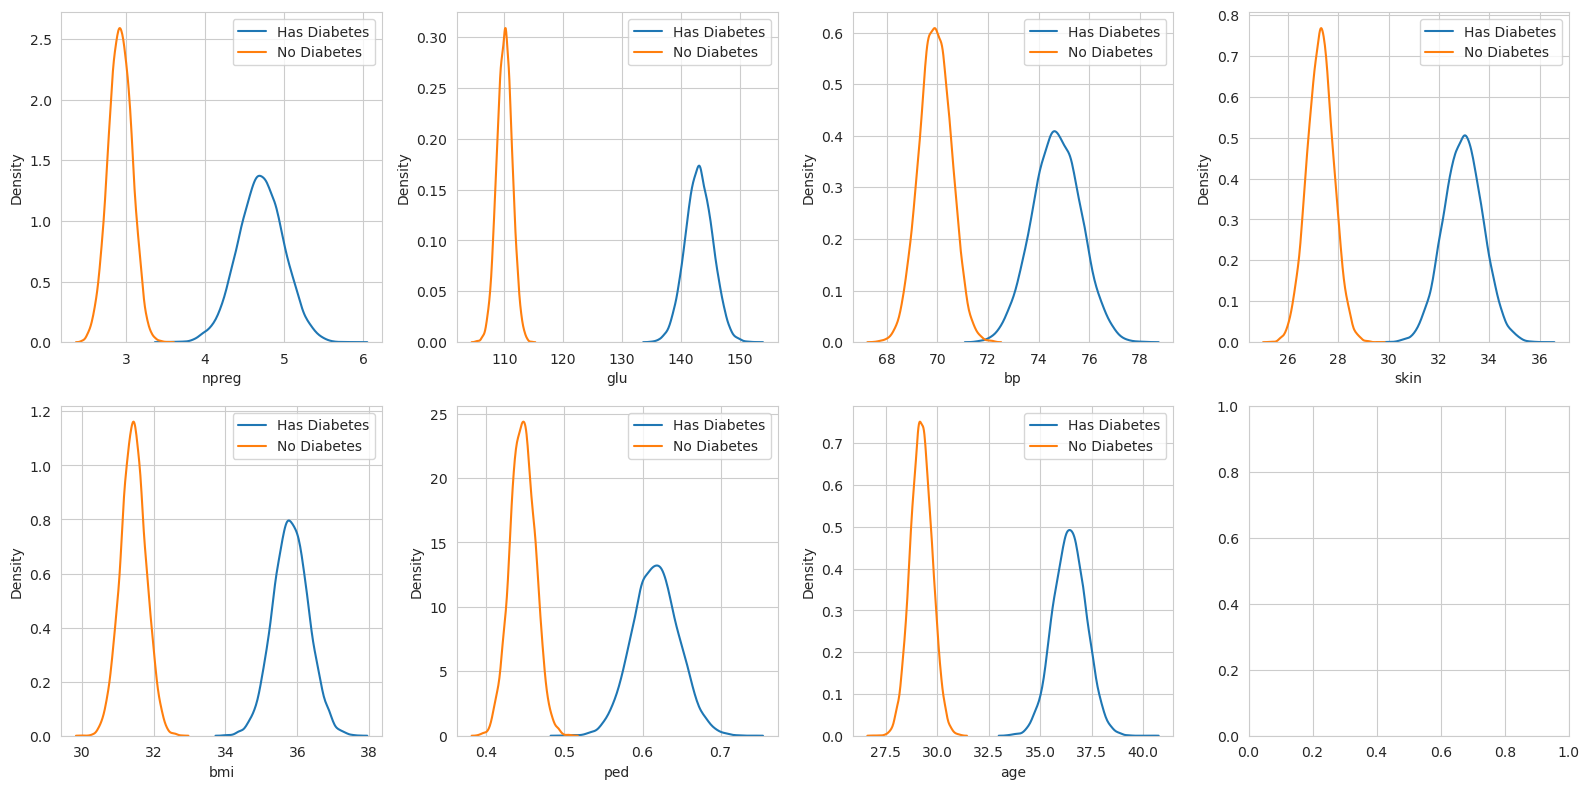

In [132]:
fig, ax = plt.subplots(2, 4, figsize=(16, 8))

for i, ((col_nm, dsr), (_, nsr)) in enumerate(zip(d_samples.iteritems(), n_samples.iteritems())):
    cur_ax = ax[i//4, i%4]
    sns.kdeplot(dsr, label="Has Diabetes", ax=cur_ax)
    sns.kdeplot(nsr, label='No Diabetes', ax=cur_ax)
    cur_ax.set_xlabel(col_nm)
    cur_ax.legend()
    print(col_name, (dsr > nsr).mean())


fig.tight_layout()
fig.show()